### Helper Classes

First we get all of our helper modules. The prepare_EMG module will prepare the EMG data for phoneme recognition. The prepare_outputs module will prepare our target labels and align them with our EMG data. The module 'prepare_data' will help us read data from CSV into a dataframe. Finally, 'vis' will help visualize EMG data in both time and frequency domains. 

In [1]:
%load_ext autoreload
%autoreload 2

import prepare_EMG, prepare_outputs, prepare_data, vis, pandas
# autodetector = Output_Prep.detector
EMG_Prep = prepare_EMG.EMG_preparer()
# Output_Prep = prepare_outputs.output_preparer(subvocal_detector = autodetector, window_size=30.0)
Output_Prep = prepare_outputs.output_preparer()

Data_Prep = prepare_data.data_preparer()



In [2]:
singles_1 = Data_Prep.load_singletons(1)
singles_2 = Data_Prep.load_singletons(2)
singles_3 = Data_Prep.load_singletons(3)

# print(singles_1.keys())

File b'simple-svr-data/raspy-1' does not exist
File b'simple-svr-data/direful-2' does not exist
File b'simple-svr-data/wrathful-2' does not exist
File b'simple-svr-data/direful-3' does not exist
File b'simple-svr-data/wrathful-3' does not exist


### Labeling the Data

First, we generate the phoneme and articulatory feature labels from each word. We'll use these to process the data in each file based on the length of the file and how many phonemes it should contain. We scale the FFT windows relative to the length of time we expect an even distribution of phonemes across the file to have. 

In [3]:
from scipy import signal
import numpy as np


labels = {}
windows = {}
for word in singles_1:
    try:
        label = Output_Prep.transform(word)
        num_phonemes = label.shape[0]
        label = label.append(Output_Prep.transform(word))
        label = label.append(Output_Prep.transform(word))
        labels[word] = label
        widths = np.linspace(0.01,10,50)
        wt_out = signal.cwt(singles_1[word]['voltage'], signal.ricker, widths)
        wt_out = pandas.DataFrame(wt_out).T
        windows[word] = EMG_Prep.process(wt_out, num_phonemes, wavelets=True)
        wt_out_2 = signal.cwt(singles_2[word]['voltage'], signal.ricker, widths)
        wt_out_2 = pandas.DataFrame(wt_out_2).T
        windows[word] = windows[word].append(EMG_Prep.process(wt_out_2, num_phonemes, wavelets=True))
        wt_out_3 = signal.cwt(singles_3[word]['voltage'], signal.ricker, widths)
        wt_out_3 = pandas.DataFrame(wt_out_3).T
        windows[word] = windows[word].append(EMG_Prep.process(wt_out_3, num_phonemes, wavelets=True))
    except Exception as inst:
        print(inst)


'direful'
'wrathful'


In [4]:
import pandas
%autoreload 2

y = pandas.DataFrame()
X = pandas.DataFrame()
for word in labels:
#     append labels to the master label dataframe
    label_frame = labels[word]
    y = y.append(label_frame)
#     Use phonemes to name each series in 'windows' for that word
    window_frame = windows[word]
    if len(label_frame.axes[0]):
        window_frame = window_frame.rename_axis(lambda x: label_frame.axes[0][x])
        X = X.append(window_frame)
    else:
        print('no labels for:',word)

print(y.head(50),X.head(50))

no labels for: direful
no labels for: wrathful
         manner      place     height vowel
D   voiced-stop   alveolar        max    no
AH        vowel        mid        mid   yes
S     fricative   alveolar        max    no
T          stop   alveolar        max    no
IY        vowel      front  very high   yes
D   voiced-stop   alveolar        max    no
AH        vowel        mid        mid   yes
S     fricative   alveolar        max    no
T          stop   alveolar        max    no
IY        vowel      front  very high   yes
D   voiced-stop   alveolar        max    no
AH        vowel        mid        mid   yes
S     fricative   alveolar        max    no
T          stop   alveolar        max    no
IY        vowel      front  very high   yes
M         nasal     labial        max    no
AA        vowel       back        low   yes
R   approximant  retroflex    mid-low    no
CH         stop      front        max    no
M         nasal     labial        max    no
AA        vowel       back   

In [5]:
# print(X.head(18), y.head(18))
from sklearn.preprocessing import scale,normalize
from sklearn.decomposition import PCA

X_scaled = scale(X)
pca = PCA(n_components=10, random_state=9)
X_reduced = pca.fit_transform(X_scaled)
X_normalized = normalize(X_reduced)

X_normalized = pandas.DataFrame(X_normalized)
X_normalized = X_normalized.rename_axis(lambda x: 'pc-'+str(x), axis='columns')
print(X_normalized)


          pc-0      pc-1      pc-2      pc-3      pc-4      pc-5      pc-6  \
0     0.576184 -0.754542 -0.050206 -0.239748  0.180560  0.053793 -0.032647   
1     0.013750 -0.926197  0.092969 -0.335421 -0.070407 -0.012713 -0.104847   
2     0.712272 -0.572587  0.364726 -0.101604 -0.016012 -0.044763 -0.106791   
3     0.798840 -0.474456  0.269973 -0.229070 -0.092277  0.010798  0.037415   
4     0.910146 -0.362559 -0.045496 -0.050948 -0.002132  0.121055 -0.139570   
5     0.088129 -0.771852 -0.391430  0.440707  0.000632 -0.166142 -0.041596   
6     0.681565 -0.326778  0.139038  0.580352 -0.104344 -0.211053 -0.038802   
7     0.797589 -0.451240  0.122891  0.304637  0.063912 -0.209512  0.023606   
8     0.766758 -0.488329  0.222714  0.331085 -0.022852 -0.106159  0.041693   
9     0.087474 -0.942711 -0.130225  0.237289  0.102326 -0.093718  0.074641   
10    0.729444  0.663096 -0.076655  0.129843 -0.048173  0.017302  0.026245   
11   -0.922918  0.200325 -0.105156  0.283830 -0.091174  0.010532

### AF Extractor Models

These models will be optimized for extracting AF's from the data, before passing those AF's onto an MLPC for identifying the most likely phoneme. 

In [6]:
# Prepare lists of parameters for our GridSearch
# First, our layer sizes
layer_sizes = []
for i in range(2,5):
    for j in range(0,180,30):
        if j:
            tup = []
            for k in range(i):
                tup.append(j)
            layer_sizes.append(tuple(tup))
print('number layer sizes:',len(layer_sizes),'here be layer sizes',layer_sizes)

# Next, our alpha values
alphas = [0.0001,1,1000]

number layer sizes: 15 here be layer sizes [(30, 30), (60, 60), (90, 90), (120, 120), (150, 150), (30, 30, 30), (60, 60, 60), (90, 90, 90), (120, 120, 120), (150, 150, 150), (30, 30, 30, 30), (60, 60, 60, 60), (90, 90, 90, 90), (120, 120, 120, 120), (150, 150, 150, 150)]


### Preparing GridSearch and Assesing Stock MLPC as AF extractor models

We setup the objects for performing gridsearch on each one of the Articulatory Feature Extractor models. We also train untuned, stock MLPC models to serve as a performance baseline. We will compare the performance of these baseline, untuned models to our gridsearched models to determine whether gridsearch has in fact improved the model parameters for each AF extractor. 

In [7]:
from sklearn.neural_network import MLPClassifier as MLPC
# Import other models to try for feature extraction
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

import copy

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.15, random_state=12)

combined_features = FeatureUnion([
    ('pca',PCA(random_state=18)),
    ('kbest',SelectKBest(k=1))
])

pipeline = Pipeline([
#     ('features', combined_features),
    ('model', MLPC(random_state=12))
])


param_grid = {
#     'features__pca__n_components':[10,20,50],
    'model__solver':['adam'],
    'model__hidden_layer_sizes':layer_sizes,
    'model__activation':['relu'],
    'model__alpha': alphas,
    'model__max_iter':[200]
}


grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1)

manner_classifier = MLPC(solver='adam',random_state=3)
manner_classifier.fit(X_train, y_train['manner'])
m_score = manner_classifier.score(X_test, y_test['manner'])

place_classifier = MLPC(solver='adam',random_state=6)
place_classifier.fit(X_train, y_train['place'])
p_score = place_classifier.score(X_test, y_test['place'])

height_classifier = MLPC(solver='adam',random_state=9)
height_classifier.fit(X_train, y_train['height'])
h_score = height_classifier.score(X_test, y_test['height'])

vowel_classifier = MLPC(solver='adam',random_state=12)
vowel_classifier.fit(X_train, y_train['vowel'])
v_score = vowel_classifier.score(X_test, y_test['vowel'])

print('manner score:',m_score,'place score:',p_score,'height score:',h_score,'vowel score:',v_score)
# print(data_1_proc.head(50), trans_labels['manner'].head(50))

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


manner score: 0.357142857143 place score: 0.258928571429 height score: 0.473214285714 vowel score: 0.616071428571


In [8]:
manner_classifier2 = copy.deepcopy(grid_search)
manner_classifier2.fit(X_train, y_train['manner'])
m_score2 = manner_classifier2.score(X_test, y_test['manner'])

print('manner score:',m_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

manner score: 0.372023809524


In [9]:
place_classifier2 = copy.deepcopy(grid_search)
place_classifier2.fit(X_train, y_train['place'])
p_score2 = place_classifier2.score(X_test, y_test['place'])

print('place score:',p_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

place score: 0.285714285714


In [10]:
height_classifier2 = copy.deepcopy(grid_search)
height_classifier2.fit(X_train, y_train['height'])
h_score2 = height_classifier2.score(X_test, y_test['height'])

print('height score:',h_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

height score: 0.491071428571


In [11]:
vowel_classifier2 = copy.deepcopy(grid_search)
vowel_classifier2.fit(X_train, y_train['vowel'])
v_score2 = vowel_classifier2.score(X_test, y_test['vowel'])

print('vowel score:',v_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


vowel score: 0.627976190476


In [16]:
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import MultiLabelBinarizer as MLB
from sklearn.preprocessing import OneHotEncoder as OHE
from collections import Counter

manner_inputs = manner_classifier2.predict(X_normalized)
place_inputs = place_classifier2.predict(X_normalized)
height_inputs = height_classifier2.predict(X_normalized)
vowel_inputs = vowel_classifier2.predict(X_normalized)

# We need to account for each value that each category of label can take on
m_count = Counter()
p_count = Counter()
h_count = Counter()
v_count = Counter()

for row in range(y.shape[0]):
    m_count.update([y.iloc[row]['manner']])
    p_count.update([y.iloc[row]['place']])
    h_count.update([y.iloc[row]['height']])
    v_count.update([y.iloc[row]['vowel']])
    
counters = [m_count,p_count,h_count,v_count]

feature_dict = {}
for count in counters:
    current = 0
    for feature in count.keys():
        feature_dict[feature] = current
        current += 1
        
# Then, we transform the predicted labels with one-hot encoding
raw_inputs = copy.deepcopy(y)
for row in range(len(raw_inputs)):

    raw_inputs.iloc[row]['manner'] = manner_inputs[row]
    raw_inputs.iloc[row]['place'] = place_inputs[row]
    raw_inputs.iloc[row]['height'] = height_inputs[row]
    raw_inputs.iloc[row]['vowel'] = vowel_inputs[row]

num_labels = copy.deepcopy(raw_inputs)
for row in range(raw_inputs.shape[0]):
    m_feat = raw_inputs.iloc[row]['manner']
    p_feat = raw_inputs.iloc[row]['place']
    h_feat = raw_inputs.iloc[row]['height']
    v_feat = raw_inputs.iloc[row]['vowel']
    num_labels.iloc[row]['manner'] = feature_dict[m_feat]
    num_labels.iloc[row]['place'] = feature_dict[p_feat]
    num_labels.iloc[row]['height'] = feature_dict[h_feat]
    num_labels.iloc[row]['vowel'] = feature_dict[v_feat]

encoder = OHE()
new_labels = encoder.fit_transform(num_labels)
enc_labels = pandas.DataFrame(new_labels.toarray())

# Finally, we build our new input DataFrame with predicted AF's and processed EMG
X_cols = list(X_normalized.axes[1]) + list(enc_labels.axes[1])

phoneme_inputs = pandas.DataFrame(columns=X_cols)
phoneme_labels = y.axes[0]

for row in range(X.shape[0]):
    new_row = X_normalized.iloc[row].append(enc_labels.iloc[row])
    new_row.name = X_normalized.iloc[row].name
    phoneme_inputs = phoneme_inputs.append(new_row)

pho_X_train, pho_X_test, pho_y_train, pho_y_test = train_test_split(phoneme_inputs, phoneme_labels, test_size=0.15, random_state=12)

In [17]:
pho_layer_sizes = []
for i in range(2,10):
    for j in range(60,120,30):
        if j:
            tup = []
            for k in range(i):
                tup.append(j)
            pho_layer_sizes.append(tuple(tup))
print('number layer sizes:',len(pho_layer_sizes),'here be layer sizes',pho_layer_sizes)

# Next, our alpha values
pho_alphas = [0.001,0.1,1,1000]

param_grid = {
#     'features__pca__n_components':[10,20,50],
    'model__solver':['adam'],
    'model__hidden_layer_sizes':pho_layer_sizes,
    'model__activation':['relu'],
    'model__alpha': pho_alphas,
    'model__max_iter':[300]
}


pho_model_grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1)

phoneme_classifier = pho_model_grid_search
phoneme_classifier.fit(pho_X_train, pho_y_train)
pho_train_f1 = phoneme_classifier.score(pho_X_train, pho_y_train)
print('phoneme classifier training score:',pho_train_f1)

number layer sizes: 16 here be layer sizes [(60, 60), (90, 90), (60, 60, 60), (90, 90, 90), (60, 60, 60, 60), (90, 90, 90, 90), (60, 60, 60, 60, 60), (90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90, 90, 90), (60, 60, 60, 60, 60, 60, 60, 60, 60), (90, 90, 90, 90, 90, 90, 90, 90, 90)]


/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Conver

phoneme classifier training score: 0.12532912059


In [19]:
pho_test_score = phoneme_classifier.score(pho_X_test, pho_y_test)
print('phoneme model test score:',pho_test_score)

phoneme model test score: 0.133928571429


In [20]:
pho2_X_train, pho2_X_test, pho2_y_train, pho2_y_test = train_test_split(X,phoneme_labels, test_size=0.15, random_state=12)

benchmark_gs = GridSearchCV(pipeline, param_grid, n_jobs=-1)

benchmark_gs.fit(pho2_X_train, pho2_y_train)
pho2_score = benchmark_gs.score(pho2_X_test,pho2_y_test)
print(pho2_score)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Conver

0.116071428571


[[ 0.65323247  0.51174206 -0.12316283 ..., -1.06757577 -0.33461919
   0.34079626]
 [ 0.62270888  0.24154018 -0.44777929 ..., -1.07061335 -0.40951928
   0.23164059]
 [ 0.45204832 -0.0409647  -0.67321999 ..., -1.05746877 -0.46992883
   0.12545211]
 ..., 
 [-0.05385709 -0.11954061 -0.18451233 ..., -0.14360704 -0.08714548
  -0.02990269]
 [-0.06540049 -0.13103255 -0.19595652 ..., -0.13336649 -0.07663081
  -0.01925887]
 [-0.01143922 -0.07731129 -0.14288978 ..., -0.17950476 -0.12340859
  -0.06646123]] (50, 441)


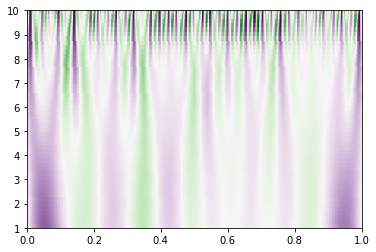

         0         1         2         3         4         5         6   \
0  0.653232  0.622709  0.452048  0.232907  0.017242 -0.172870 -0.329926   
1  0.511742  0.241540 -0.040965 -0.281178 -0.470909 -0.614035 -0.716585   
2 -0.123163 -0.447779 -0.673220 -0.825506 -0.926463 -0.988533 -1.019664   
3 -0.964397 -1.101572 -1.167120 -1.198850 -1.207185 -1.195977 -1.168241   
4 -1.342164 -1.306838 -1.281766 -1.257053 -1.223840 -1.180274 -1.126974   

         7         8         9     ...           40        41        42  \
0 -0.095789 -0.222927 -0.323578    ...    -0.053162 -0.060858 -0.069204   
1 -0.452902 -0.543705 -0.605462    ...    -0.118614 -0.126147 -0.134389   
2 -0.784432 -0.822868 -0.836752    ...    -0.182461 -0.189932 -0.198162   
3 -1.025689 -1.011164 -0.980365    ...    -0.244155 -0.251713 -0.260044   
4 -1.126484 -1.073195 -1.011745    ...    -0.303220 -0.311025 -0.319591   

         43        44        45        46        47        48        49  
0 -0.012242 -0.021905 -0

In [71]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

sig = singles_2['talented']['voltage']
widths = np.linspace(2,20,50)
wt_out = signal.cwt(sig, signal.ricker, widths)
print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, 1, 1, 10],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T
print(wt_out_frame.head())

[[ 0.54838172  0.72045563  0.59004801 ...,  0.23920663  0.15588348
  -0.00118004]
 [ 0.71474948  0.74894265  0.42752103 ...,  0.25632161  0.16402265
   0.05797607]
 [ 0.76785585  0.63311763  0.18378103 ...,  0.30311367  0.21181612
   0.12568745]
 ..., 
 [ 0.14450884  0.07892496  0.01275487 ..., -0.2272032  -0.14865046
  -0.06933685]
 [ 0.13322028  0.06794758  0.00220121 ..., -0.21476608 -0.1374704
  -0.0594979 ]
 [ 0.18605869  0.1219844   0.05705772 ..., -0.27724368 -0.20243818
  -0.12638601]] (50, 650) (650,)


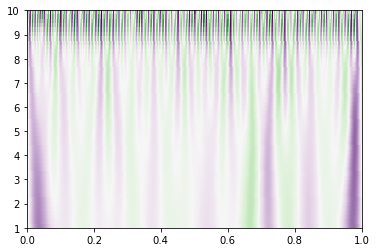

In [72]:
sig2 = singles_3['stereotyped']['voltage']
# widths = np.linspace(0.005,10)
wt_out2 = signal.cwt(sig2, signal.ricker, widths)
print (wt_out2, wt_out2.shape, sig2.shape)
plt.imshow(wt_out2, extent=[0, 1, 1, 10],cmap='PRGn',aspect='auto',vmax=abs(wt_out2).max(), vmin=-abs(wt_out2).max())
plt.show()

[[-0.69630524 -0.87908303 -0.53319098 ...,  0.24902621  0.19852331
   0.12187347]
 [-0.72998361 -0.84250901 -0.57511286 ...,  0.32063257  0.26688456
   0.18955826]
 [-0.73500098 -0.78681909 -0.53198711 ...,  0.34251187  0.33241958
   0.27192112]
 ..., 
 [-0.19755695 -0.26615804 -0.33216414 ...,  0.0649744   0.16111789
   0.25492423]
 [-0.20379763 -0.27146687 -0.33660312 ...,  0.07216291  0.16768235
   0.26086621]
 [-0.14119938 -0.20997017 -0.27675299 ..., -0.01745655  0.07912513
   0.17401884]] (50, 642) (642,)


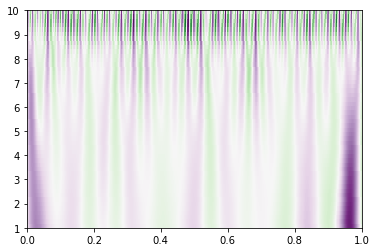

In [73]:
sig3 = singles_1['weather']['voltage']
# widths = np.linspace(0.005,10)
wt_out3 = signal.cwt(sig3, signal.ricker, widths)
print (wt_out3, wt_out3.shape, sig3.shape)
plt.imshow(wt_out3, extent=[0, 1, 1, 10],cmap='PRGn',aspect='auto',vmax=abs(wt_out3).max(), vmin=-abs(wt_out3).max())
plt.show()

D represents 4.429530201342282% of all samples
AH represents 9.261744966442953% of all samples
S represents 7.114093959731544% of all samples
T represents 7.785234899328859% of all samples
IY represents 4.026845637583892% of all samples
M represents 2.953020134228188% of all samples
AA represents 1.6107382550335572% of all samples
R represents 5.100671140939597% of all samples
CH represents 0.8053691275167786% of all samples
K represents 6.174496644295302% of all samples
P represents 3.48993288590604% of all samples
L represents 4.697986577181208% of all samples
UH represents 0.4026845637583893% of all samples
ER represents 2.953020134228188% of all samples
B represents 2.2818791946308723% of all samples
OY represents 0.1342281879194631% of all samples
Z represents 1.476510067114094% of all samples
W represents 1.74496644295302% of all samples
EY represents 1.476510067114094% of all samples
N represents 6.174496644295302% of all samples
V represents 1.6107382550335572% of all samples
I

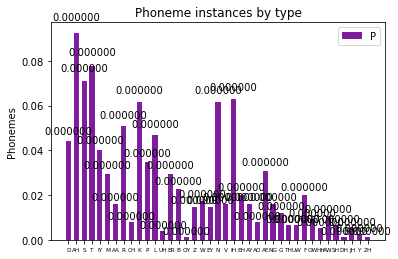

In [49]:
phonemes = Counter(phoneme_labels)
N = len(phonemes)

total = sum(phonemes.values())
for key in phonemes:
    phonemes[key] = phonemes[key] / total
    print(key, "represents", str(phonemes[key]*100)+"%","of all samples")
ind = np.arange(N)  # the x locations for the groups
width = .66       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, phonemes.values(), width, color='xkcd:purple')

# add some text for labels, title and axes ticks
ax.set_ylabel('Phonemes')
ax.set_title('Phoneme instances by type')
ax.set_xticks(ind)
ax.set_xticklabels(phonemes.keys(),size='xx-small')

ax.legend('Phonemes')


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()